In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os
from glob import glob

from tqdm import tqdm

import h5py

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from warnings import filterwarnings

# Dataset import

In [3]:
directory = f'/home/bariskurtkaya/github//AI-Boosted-Coronagraphy/dataset/NIRCAM'

In [4]:
h5_files = glob(os.path.join(directory,'**/*.h5'))

In [5]:
h5_files

['/home/bariskurtkaya/github//AI-Boosted-Coronagraphy/dataset/NIRCAM/1386/1386__psfstack_sci.h5']

In [6]:
class MyH5Dataset(Dataset):
    
    def __init__(self,h5_paths):
        
        self.h5_paths  = h5_paths
        self._archives = [h5py.File(h5_path,"r") for h5_path in self.h5_paths]
        self.keys      = {}
        self.d = {}
        
        idx  = 0
        idx2 = 0
        
        
        for a, archive in enumerate(self.archives):
            
            for i in range(len(archive)):
                
                key = list(archive.keys())[i]  
                self.keys[idx] = (a, key)
                idx += 1
                
                for j in range(archive[key].shape[0]):
                    
                    self.d[idx2] = archive[key][j]
                    idx2 +=1
                    
        self._archive=None
    @property
    def archives(self):
        if self._archives is None: 
            self._archives = [h5py.File(h5_path, "r") for h5_path in self.h5_paths]
        return self._archives
    
    def __len__(self):
        return len(self.d)
    
    def __getitem__(self,index):
        
        data = self.d[index].astype(np.float32)
        data = torch.from_numpy(data)
        
        return data

In [7]:
loader = torch.utils.data.DataLoader(MyH5Dataset(h5_files))
doenum = enumerate(loader)
idx,data = next(doenum)

In [8]:
data.shape

torch.Size([1, 320, 320])

# Conv AutoEncoder

In [9]:
filterwarnings('ignore')
device = torch.device('cuda:0')

In [10]:
if device.type == 'cuda':
    print('Total GPU count:', torch.cuda.device_count())
    print('Selected GPU index:', torch.cuda.current_device())
    current_device = torch.cuda.current_device()
    print('Selected GPU Name:', torch.cuda.get_device_name(current_device))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(current_device)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(current_device)/1024**3,1), 'GB')
    print('Max Memmory Cached:', round(torch.cuda.max_memory_cached(current_device)/1024**3,1), 'GB')


Total GPU count: 4
Selected GPU index: 0
Selected GPU Name: NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Max Memmory Cached: 0.0 GB


In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1), # 320*320*1 -> 316*316*8
            #nn.BatchNorm2d(8), #Possible comment line
            nn.LeakyReLU(),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1), # 316*316*8 -> 312*312*16
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2), # 312*312*16 -> 155*155*32
            #nn.BatchNorm2d(32), #Possible comment line
            nn.LeakyReLU(),
            # Fourth convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2), # 155*155*32 -> 76*76*64
            #nn.BatchNorm2d(64), #Possible comment line
            nn.LeakyReLU()
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(76 * 76 * 64, 1024),
            nn.LeakyReLU(),
            # Second linear layer
            nn.Linear(1024, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 1024),
            nn.LeakyReLU(),
            # Second linear layer
            nn.Linear(1024, 76 * 76 * 64),
            nn.LeakyReLU()
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 76, 76))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(64, 32, 5, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            #Second transposed convolution
            nn.ConvTranspose2d(32, 16, 4, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            # Third transposed convolution
            nn.ConvTranspose2d(16, 8, 5, stride=1),
            #nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            # Fourth transposed convolution
            nn.ConvTranspose2d(8, 1, 5, stride=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
     

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 128

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)

In [14]:
encoder, decoder

(Encoder(
   (encoder_cnn): Sequential(
     (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
     (1): LeakyReLU(negative_slope=0.01)
     (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
     (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.01)
     (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
     (6): LeakyReLU(negative_slope=0.01)
     (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
     (8): LeakyReLU(negative_slope=0.01)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (encoder_lin): Sequential(
     (0): Linear(in_features=369664, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=1024, out_features=128, bias=True)
   )
 ),
 Decoder(
   (decoder_lin): Sequential(
     (0): Linear(in_features=128, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=1024, out_features=369664, bias=

In [15]:
encoder = torch.load('models/encoder_1200.pt')
decoder = torch.load('models/decoder_1200.pt')

In [16]:
encoder, decoder

(Encoder(
   (encoder_cnn): Sequential(
     (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
     (1): LeakyReLU(negative_slope=0.01)
     (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
     (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.01)
     (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
     (6): LeakyReLU(negative_slope=0.01)
     (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
     (8): LeakyReLU(negative_slope=0.01)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (encoder_lin): Sequential(
     (0): Linear(in_features=369664, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=1024, out_features=128, bias=True)
   )
 ),
 Decoder(
   (decoder_lin): Sequential(
     (0): Linear(in_features=128, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=1024, out_features=369664, bias=

In [17]:
### Some examples
# Take an input image (remember to add the batch dimension)
idx,data = next(doenum)
data = data.unsqueeze(0).to(device) # Add the batch dimension in the first axis
print('Original image shape:', data.shape)
# Encode the image

img_enc = encoder(data)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 320, 320])
Encoded image shape: torch.Size([1, 128])
Decoded image shape: torch.Size([1, 1, 320, 320])


In [18]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=369664, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 76, 76))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [19]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for _, image_batch in enumerate(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        #print(image_batch.shape)
        image_batch = image_batch.unsqueeze(0)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [20]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [21]:
def plot_ae_outputs(encoder,decoder,data,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = data.unsqueeze(0).to(device)
        #print(img.shape)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

torch.Size([1, 1, 320, 320])


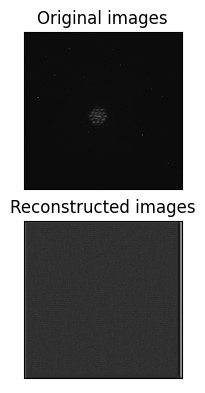


 EPOCH 1/2500 	 train loss 1867.302
torch.Size([1, 1, 320, 320])


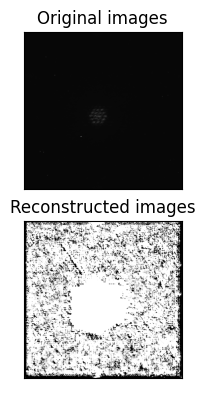


 EPOCH 11/2500 	 train loss 1865.040
torch.Size([1, 1, 320, 320])


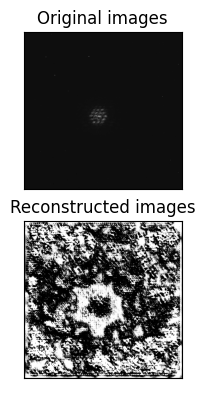


 EPOCH 21/2500 	 train loss 1865.094
torch.Size([1, 1, 320, 320])


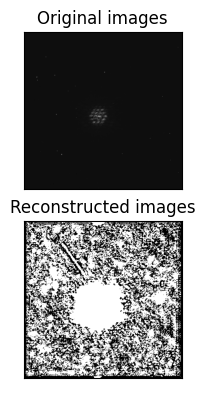


 EPOCH 31/2500 	 train loss 1865.008
torch.Size([1, 1, 320, 320])


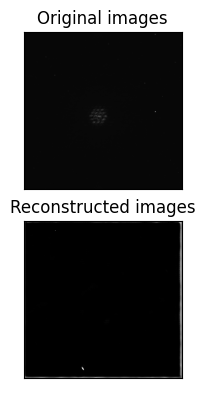


 EPOCH 41/2500 	 train loss 1865.141
torch.Size([1, 1, 320, 320])


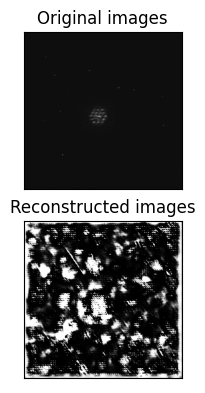


 EPOCH 51/2500 	 train loss 1865.068
torch.Size([1, 1, 320, 320])


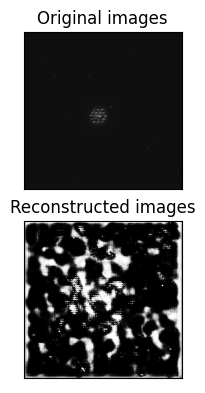


 EPOCH 61/2500 	 train loss 1865.045
torch.Size([1, 1, 320, 320])


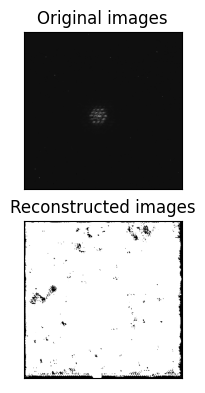


 EPOCH 71/2500 	 train loss 1865.046
torch.Size([1, 1, 320, 320])


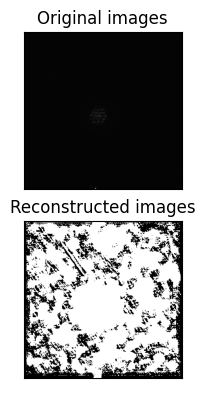


 EPOCH 81/2500 	 train loss 1865.058
torch.Size([1, 1, 320, 320])


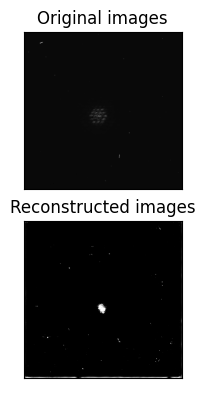


 EPOCH 91/2500 	 train loss 1865.027
torch.Size([1, 1, 320, 320])


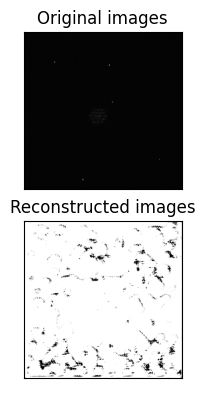


 EPOCH 101/2500 	 train loss 1865.029
torch.Size([1, 1, 320, 320])


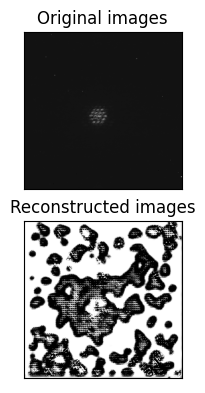


 EPOCH 111/2500 	 train loss 1864.986
torch.Size([1, 1, 320, 320])


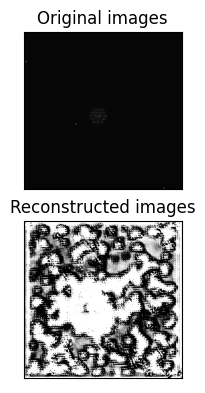


 EPOCH 121/2500 	 train loss 1864.964
torch.Size([1, 1, 320, 320])


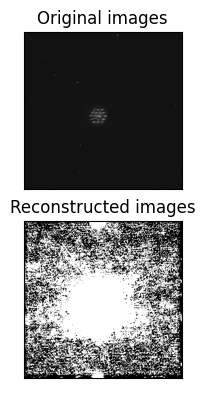


 EPOCH 131/2500 	 train loss 1864.953
torch.Size([1, 1, 320, 320])


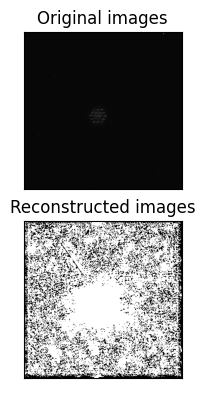


 EPOCH 141/2500 	 train loss 1864.902
torch.Size([1, 1, 320, 320])


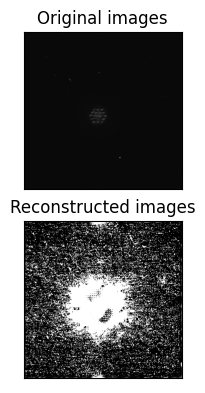


 EPOCH 151/2500 	 train loss 1864.896
torch.Size([1, 1, 320, 320])


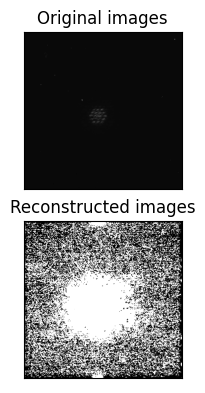


 EPOCH 161/2500 	 train loss 1864.880
torch.Size([1, 1, 320, 320])


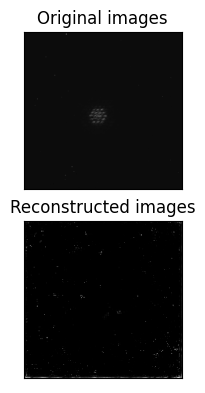


 EPOCH 171/2500 	 train loss 1864.871
torch.Size([1, 1, 320, 320])


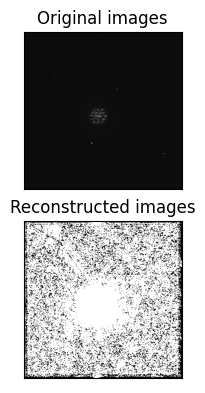


 EPOCH 181/2500 	 train loss 1864.862
torch.Size([1, 1, 320, 320])


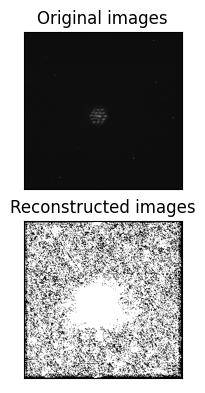


 EPOCH 191/2500 	 train loss 1864.863
torch.Size([1, 1, 320, 320])


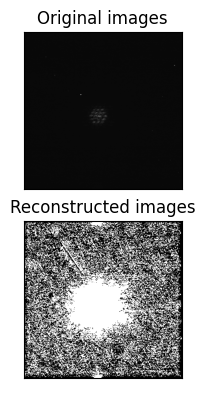


 EPOCH 201/2500 	 train loss 1864.852
torch.Size([1, 1, 320, 320])


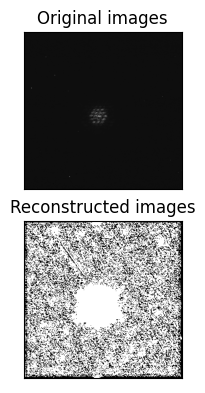


 EPOCH 211/2500 	 train loss 1864.854
torch.Size([1, 1, 320, 320])


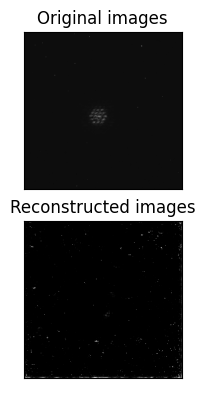


 EPOCH 221/2500 	 train loss 1864.854
torch.Size([1, 1, 320, 320])


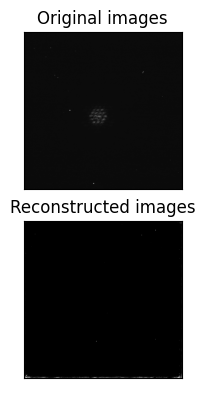


 EPOCH 231/2500 	 train loss 1864.848
torch.Size([1, 1, 320, 320])


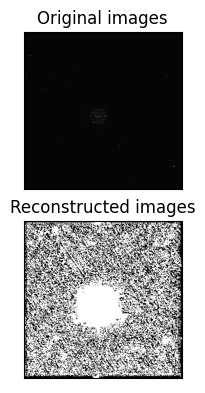


 EPOCH 241/2500 	 train loss 1864.847
torch.Size([1, 1, 320, 320])


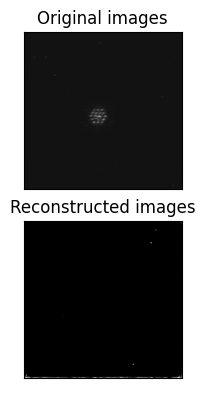


 EPOCH 251/2500 	 train loss 1864.852
torch.Size([1, 1, 320, 320])


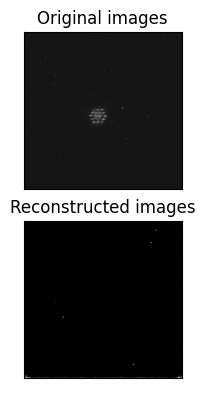


 EPOCH 261/2500 	 train loss 1864.858
torch.Size([1, 1, 320, 320])


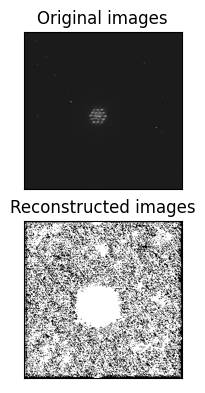


 EPOCH 271/2500 	 train loss 1864.847
torch.Size([1, 1, 320, 320])


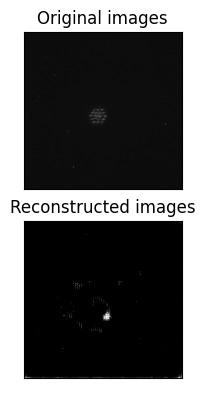


 EPOCH 281/2500 	 train loss 1864.852
torch.Size([1, 1, 320, 320])


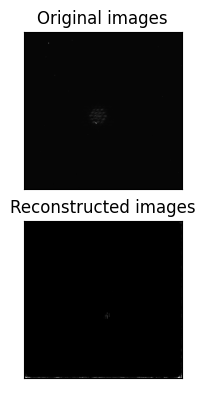


 EPOCH 291/2500 	 train loss 1864.839
torch.Size([1, 1, 320, 320])


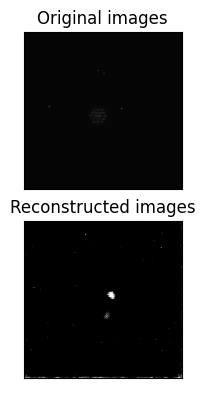


 EPOCH 301/2500 	 train loss 1864.842
torch.Size([1, 1, 320, 320])


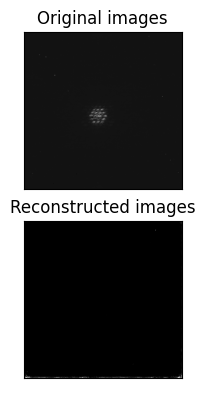


 EPOCH 311/2500 	 train loss 1864.850
torch.Size([1, 1, 320, 320])


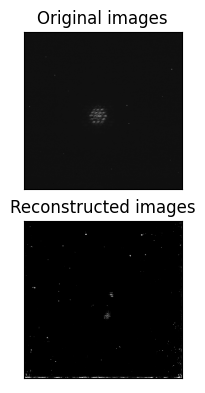


 EPOCH 321/2500 	 train loss 1864.861
torch.Size([1, 1, 320, 320])


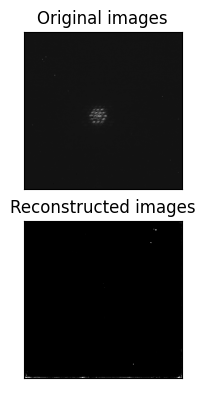


 EPOCH 331/2500 	 train loss 1864.842
torch.Size([1, 1, 320, 320])


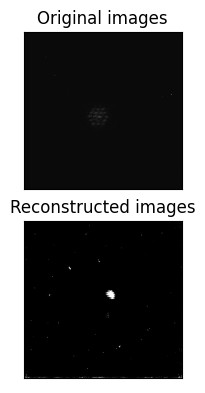


 EPOCH 341/2500 	 train loss 1864.839
torch.Size([1, 1, 320, 320])


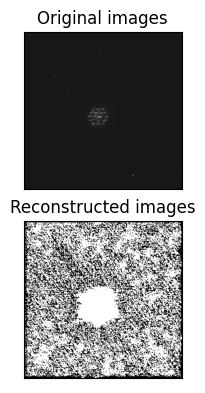


 EPOCH 351/2500 	 train loss 1864.838
torch.Size([1, 1, 320, 320])


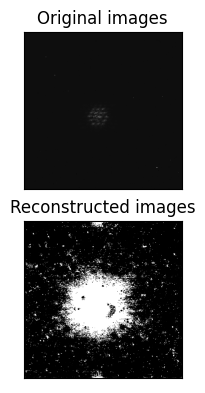


 EPOCH 361/2500 	 train loss 1864.859
torch.Size([1, 1, 320, 320])


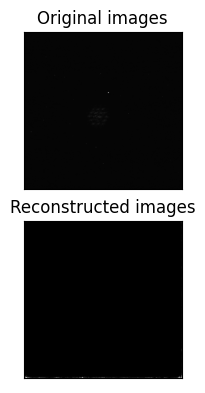


 EPOCH 371/2500 	 train loss 1864.835
torch.Size([1, 1, 320, 320])


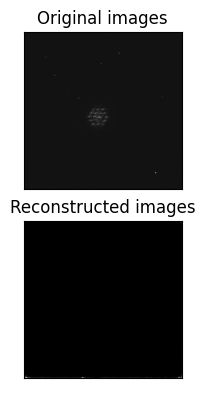


 EPOCH 381/2500 	 train loss 1864.843
torch.Size([1, 1, 320, 320])


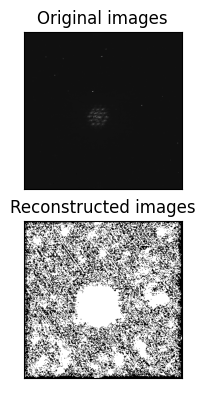


 EPOCH 391/2500 	 train loss 1864.832
torch.Size([1, 1, 320, 320])


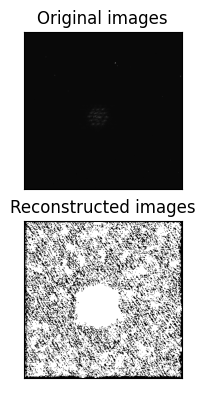


 EPOCH 401/2500 	 train loss 1864.850
torch.Size([1, 1, 320, 320])


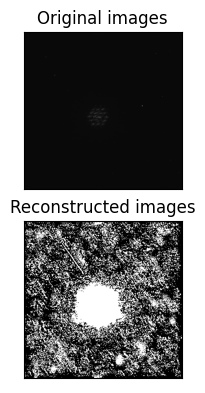


 EPOCH 411/2500 	 train loss 1864.837
torch.Size([1, 1, 320, 320])


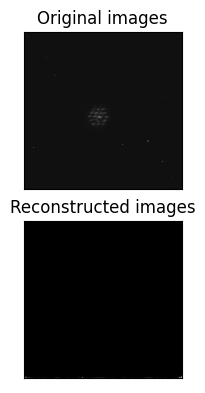


 EPOCH 421/2500 	 train loss 1864.835
torch.Size([1, 1, 320, 320])


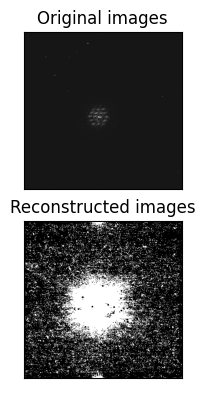


 EPOCH 431/2500 	 train loss 1864.838
torch.Size([1, 1, 320, 320])


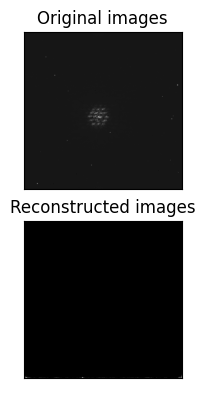


 EPOCH 441/2500 	 train loss 1864.832
torch.Size([1, 1, 320, 320])


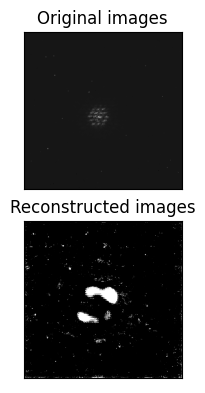


 EPOCH 451/2500 	 train loss 1864.835
torch.Size([1, 1, 320, 320])


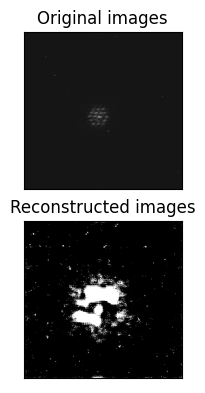


 EPOCH 461/2500 	 train loss 1864.837
torch.Size([1, 1, 320, 320])


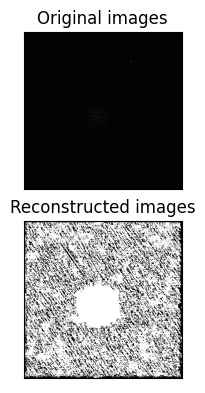


 EPOCH 471/2500 	 train loss 1864.866
torch.Size([1, 1, 320, 320])


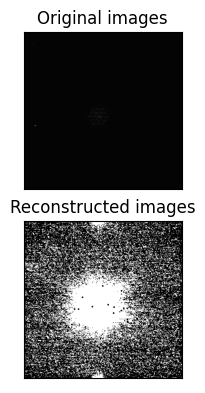


 EPOCH 481/2500 	 train loss 1864.829
torch.Size([1, 1, 320, 320])


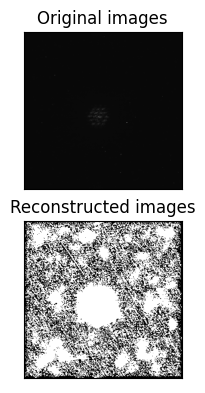


 EPOCH 491/2500 	 train loss 1864.847
torch.Size([1, 1, 320, 320])


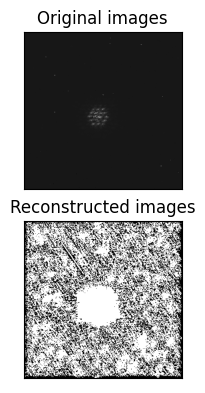


 EPOCH 501/2500 	 train loss 1864.836
torch.Size([1, 1, 320, 320])


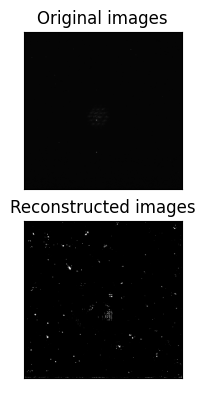


 EPOCH 511/2500 	 train loss 1864.840
torch.Size([1, 1, 320, 320])


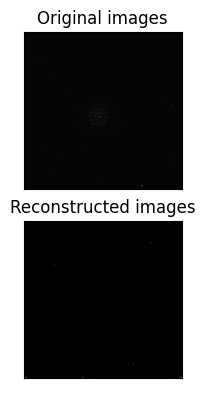


 EPOCH 521/2500 	 train loss 1864.833
torch.Size([1, 1, 320, 320])


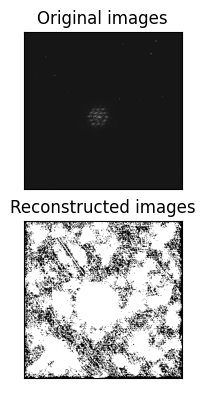


 EPOCH 531/2500 	 train loss 1864.835
torch.Size([1, 1, 320, 320])


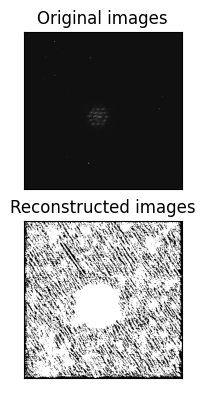


 EPOCH 541/2500 	 train loss 1864.908
torch.Size([1, 1, 320, 320])


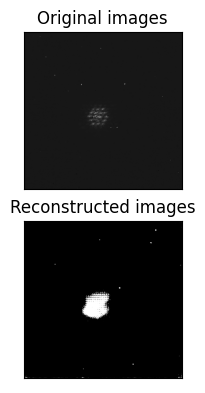


 EPOCH 551/2500 	 train loss 1864.824
torch.Size([1, 1, 320, 320])


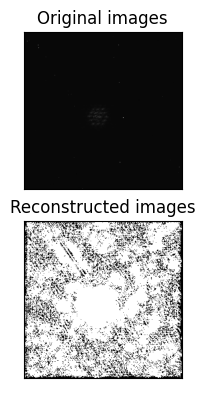


 EPOCH 561/2500 	 train loss 1864.836
torch.Size([1, 1, 320, 320])


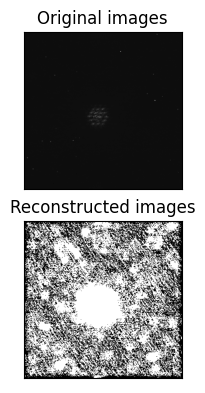


 EPOCH 571/2500 	 train loss 1864.826
torch.Size([1, 1, 320, 320])


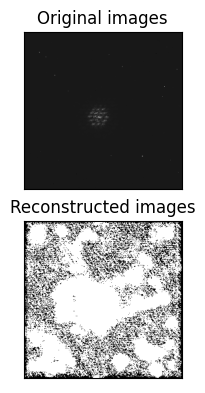


 EPOCH 581/2500 	 train loss 1864.857
torch.Size([1, 1, 320, 320])


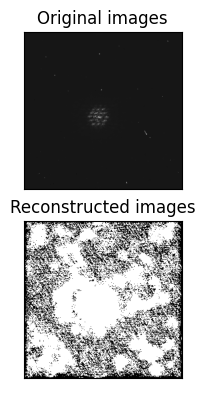


 EPOCH 591/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


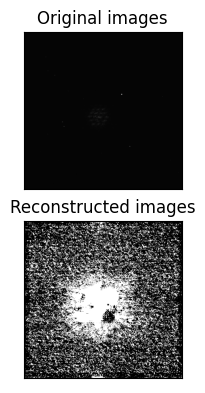


 EPOCH 601/2500 	 train loss 1864.826
torch.Size([1, 1, 320, 320])


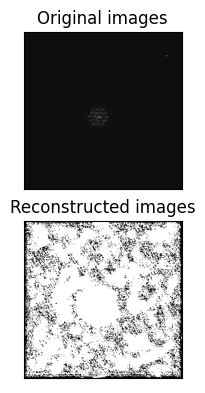


 EPOCH 611/2500 	 train loss 1864.831
torch.Size([1, 1, 320, 320])


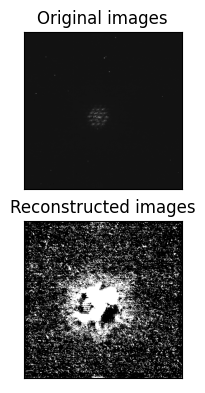


 EPOCH 621/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


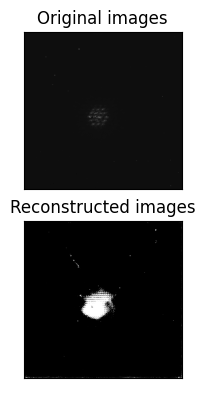


 EPOCH 631/2500 	 train loss 1864.828
torch.Size([1, 1, 320, 320])


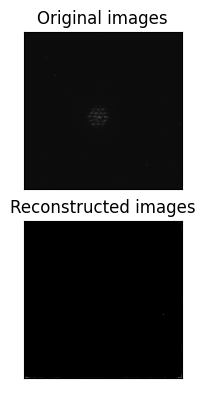


 EPOCH 641/2500 	 train loss 1864.823
torch.Size([1, 1, 320, 320])


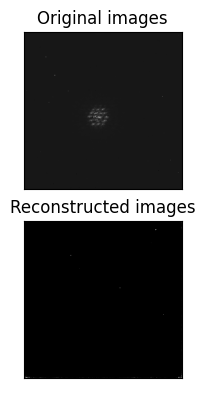


 EPOCH 651/2500 	 train loss 1864.834
torch.Size([1, 1, 320, 320])


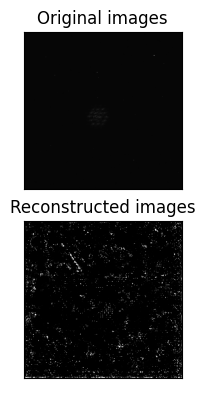


 EPOCH 661/2500 	 train loss 1864.833
torch.Size([1, 1, 320, 320])


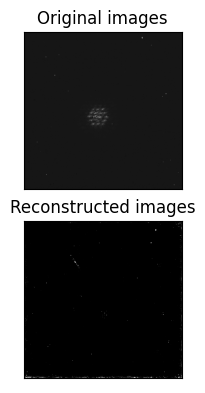


 EPOCH 671/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


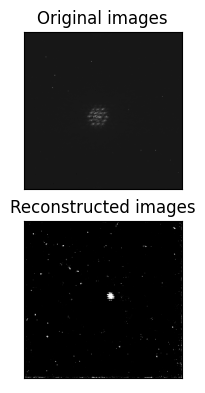


 EPOCH 681/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


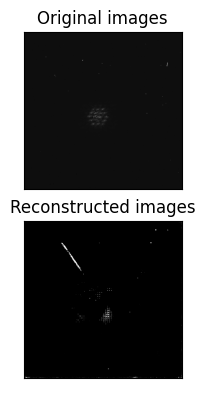


 EPOCH 691/2500 	 train loss 1864.849
torch.Size([1, 1, 320, 320])


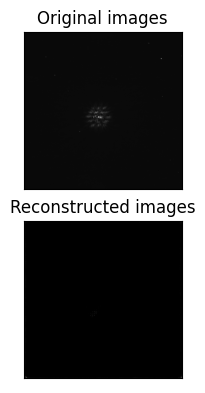


 EPOCH 701/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


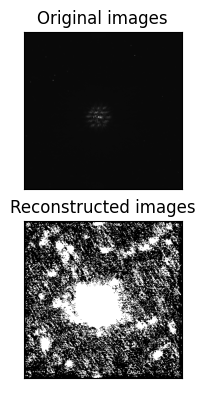


 EPOCH 711/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


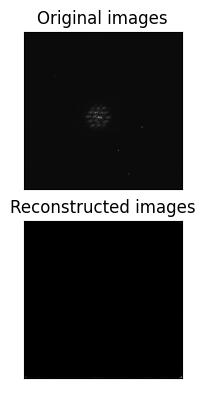


 EPOCH 721/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


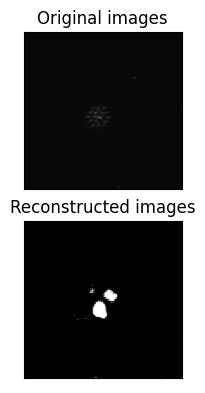


 EPOCH 731/2500 	 train loss 1864.821
torch.Size([1, 1, 320, 320])


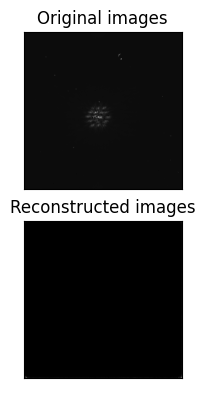


 EPOCH 741/2500 	 train loss 1864.821
torch.Size([1, 1, 320, 320])


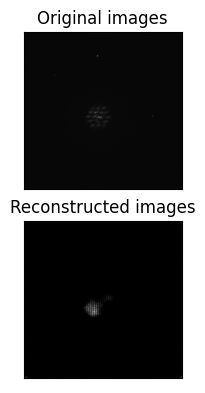


 EPOCH 751/2500 	 train loss 1864.820
torch.Size([1, 1, 320, 320])


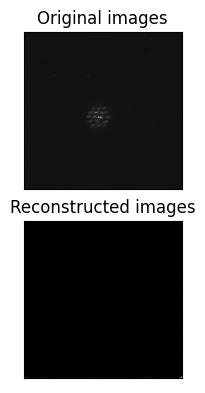


 EPOCH 761/2500 	 train loss 1864.831
torch.Size([1, 1, 320, 320])


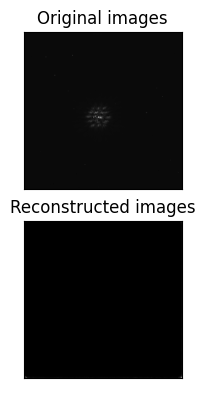


 EPOCH 771/2500 	 train loss 1864.819
torch.Size([1, 1, 320, 320])


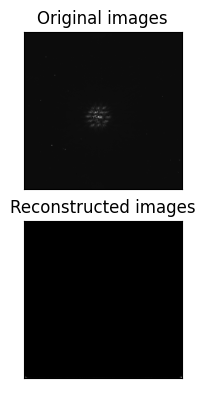


 EPOCH 781/2500 	 train loss 1864.842
torch.Size([1, 1, 320, 320])


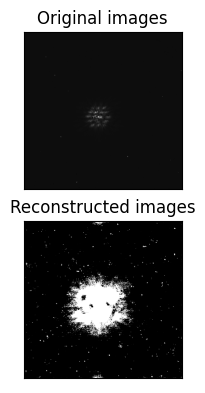


 EPOCH 791/2500 	 train loss 1864.831
torch.Size([1, 1, 320, 320])


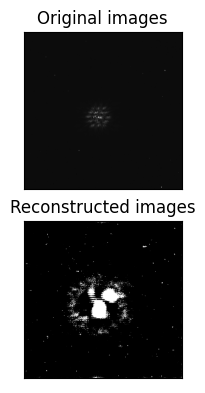


 EPOCH 801/2500 	 train loss 1864.823
torch.Size([1, 1, 320, 320])


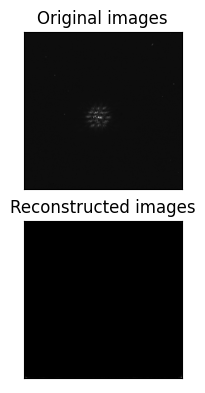


 EPOCH 811/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


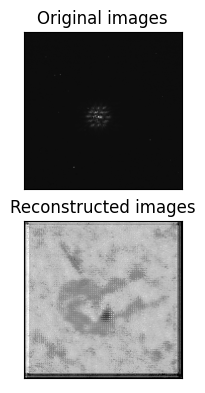


 EPOCH 821/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


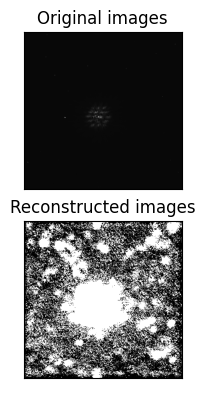


 EPOCH 831/2500 	 train loss 1864.819
torch.Size([1, 1, 320, 320])


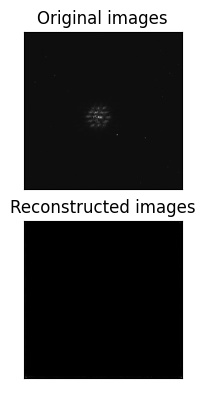


 EPOCH 841/2500 	 train loss 1864.821
torch.Size([1, 1, 320, 320])


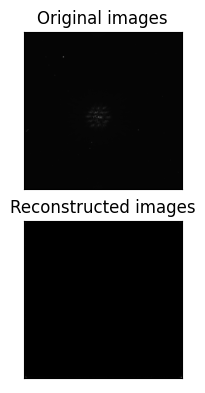


 EPOCH 851/2500 	 train loss 1864.825
torch.Size([1, 1, 320, 320])


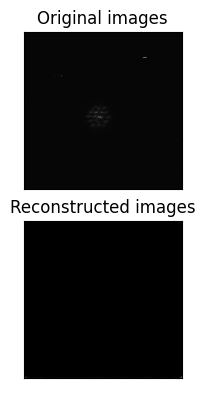


 EPOCH 861/2500 	 train loss 1864.817
torch.Size([1, 1, 320, 320])


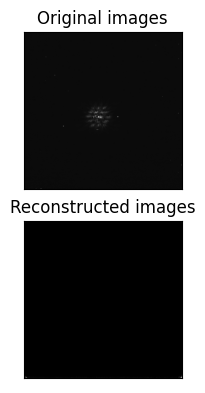


 EPOCH 871/2500 	 train loss 1864.832
torch.Size([1, 1, 320, 320])


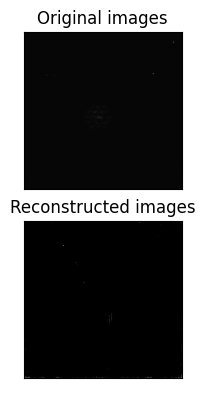


 EPOCH 881/2500 	 train loss 1864.818
torch.Size([1, 1, 320, 320])


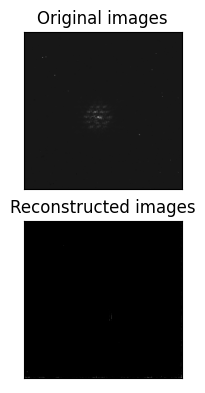


 EPOCH 891/2500 	 train loss 1864.821
torch.Size([1, 1, 320, 320])


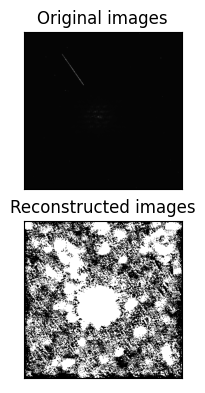


 EPOCH 901/2500 	 train loss 1864.821
torch.Size([1, 1, 320, 320])


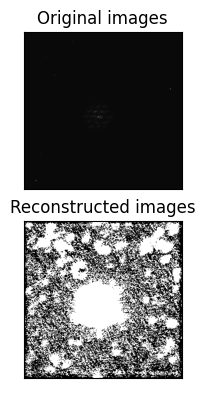


 EPOCH 911/2500 	 train loss 1864.824
torch.Size([1, 1, 320, 320])


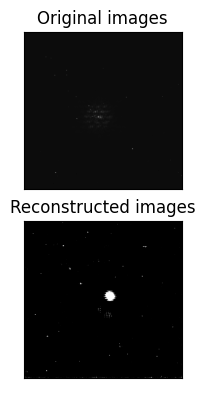


 EPOCH 921/2500 	 train loss 1864.830
torch.Size([1, 1, 320, 320])


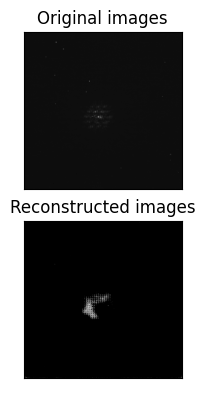


 EPOCH 931/2500 	 train loss 1864.820
torch.Size([1, 1, 320, 320])


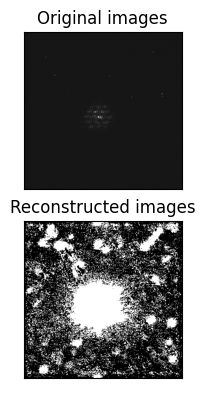


 EPOCH 941/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


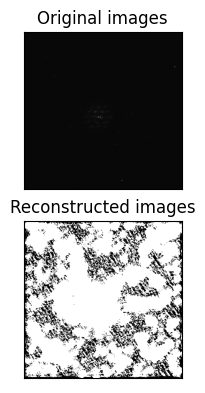


 EPOCH 951/2500 	 train loss 1864.829
torch.Size([1, 1, 320, 320])


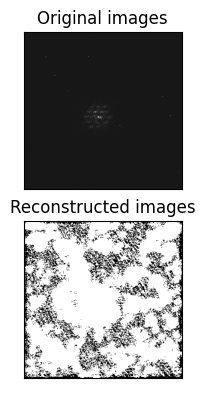


 EPOCH 961/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


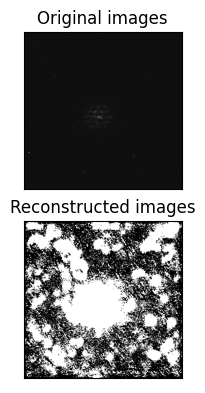


 EPOCH 971/2500 	 train loss 1864.819
torch.Size([1, 1, 320, 320])


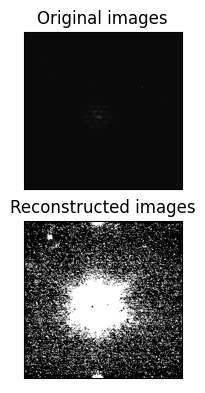


 EPOCH 981/2500 	 train loss 1864.836
torch.Size([1, 1, 320, 320])


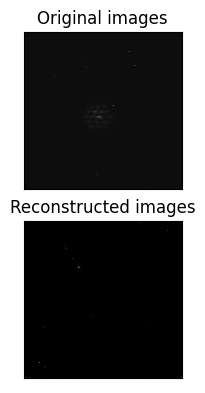


 EPOCH 991/2500 	 train loss 1864.822
torch.Size([1, 1, 320, 320])


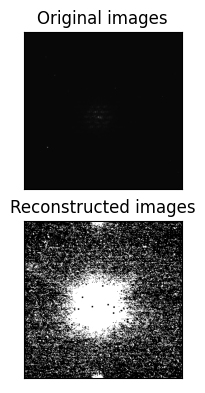


 EPOCH 1001/2500 	 train loss 1864.823


In [ ]:
num_epochs = 2500
history={'train_loss':[],'val_loss':[]}

lr = 0.01
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

for epoch in range(num_epochs):
    if epoch == 1000:
        lr = 0.0008
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
    elif epoch == 500:
        lr = 0.001
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
    
    if epoch % 10 == 0:
        _,data = next(doenum)
        plot_ae_outputs(encoder, decoder, data, 1)
    if epoch % 100 == 0 and epoch!= 0:
        torch.save(encoder,f'models/encoder_{epoch + 1200}.pt')
        torch.save(decoder,f'models/decoder_{epoch + 1200}.pt')

        
    
    train_loss = train_epoch(encoder,decoder,device,loader,loss_fn,optim)
    
    #val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
    #print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    
    if epoch % 10 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss)) 
    history['train_loss'].append(train_loss)
    
    #history['val_loss'].append(val_loss)

torch.Size([1, 320, 320])


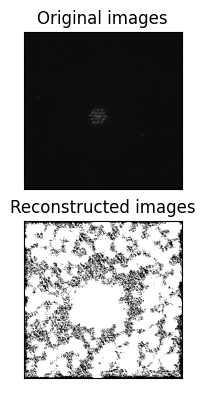

In [22]:
idx,data = next(doenum)

print(data.shape)

plot_ae_outputs(encoder, decoder, data, 1)

# Parameter Count

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
print( round(((count_parameters(encoder) + count_parameters(decoder) ) * 8 )/1024**3, 3) , 'GB')

5.646 GB


In [29]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [30]:
count_parameters(encoder), count_parameters(decoder)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| encoder_cnn.0.weight |    200     |
|  encoder_cnn.0.bias  |     8      |
| encoder_cnn.2.weight |    3200    |
|  encoder_cnn.2.bias  |     16     |
| encoder_cnn.3.weight |     16     |
|  encoder_cnn.3.bias  |     16     |
| encoder_cnn.5.weight |    8192    |
|  encoder_cnn.5.bias  |     32     |
| encoder_cnn.7.weight |   51200    |
|  encoder_cnn.7.bias  |     64     |
| encoder_lin.0.weight | 378535936  |
|  encoder_lin.0.bias  |    1024    |
| encoder_lin.2.weight |   131072   |
|  encoder_lin.2.bias  |    128     |
+----------------------+------------+
Total Trainable Params: 378731104
+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|  decoder_lin.0.weight |   131072   |
|   decoder_lin.0.bias  |    1024    |
|  decoder_lin.2.weight | 378535936  |
|   decoder_lin.2.bias  |   369664   |
| decoder

(378731104, 379100641)